In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import scipy as sp
import pathlib
import pickle
from matplotlib import pyplot as plt
from pylab import figure, cm
from matplotlib.colors import LogNorm
from scipy import interpolate
import stereoid.utils.config as st_config

### Read data

In [2]:
### paths
paths = st_config.parse(config_file_path=pathlib.Path("/Users/marcelmac/Data/Harmony/PAR/mac_defaults.cfg"),section="Paths")
# Unpack the paths read from user.cfg. If user.cfg is not found user_defaults.cfg is used.
main_dir = paths["main"]
datadir = paths["data"]
pardir = paths["par"]
resultsdir = paths["results"]

# TC settings
xres=1000
yres=1000
shp=(300,500)
si=(shp[0]*yres,shp[1]*xres)
wind_field='Holland'
u_m=50
R_m=40E3
B=1.5
lat=np.deg2rad(20)
v_eye=5
dir_eye=-45 # it is with respect to North
phi_in=20

# file input paths
inpath=str(resultsdir) + '/TropicalCyclones/'
pattern=f'Size_{int(si[1]/1000)}_{str(si[1]/1000)}_rot_{int(u_m)}_{int(R_m/1000)}_{int(phi_in)}_trans_{int(v_eye)}_{int(dir_eye)}_loc_{int(lat)}.pkl'
inpath = inpath + wind_field + '/'
inwind = inpath + 'WindGrid/' + pattern
intrains = inpath + 'WaveTrains/' + pattern
incutoff = inpath + 'Cutoff/' + pattern
inspec = inpath + 'Spectra/' + pattern
inwave = inpath + 'WaveSpectra/' + pattern
insigma = inpath + 'Scatter/' + pattern
indopp = inpath + 'Doppler/' + pattern
indoppvel = inpath + 'DopplerVelocity/' + pattern

# output figures
outpath='/Users/marcelmac/Documents/Papers/HarmonyTropicalCyclones/Figures/'

/Users/marcelmac/PythonProjects/stereoid /Users/marcelmac/Data/Harmony/PAR/mac_defaults.cfg


In [3]:
### read files
with open(inwind,'rb') as f:
        (x,y,vx,vy)=pickle.load(f)
with open(intrains,'rb') as f:
        (x_wt, y_wt, c_gp, e, phi_p, WI)=pickle.load(f)
with open(incutoff,'rb') as f:
        (Cm,Ch1,Ch2)=pickle.load(f)        
with open(inspec,'rb') as f:
        (Pm,Ph1,Ph2)=pickle.load(f)
with open(inwave,'rb') as f:
        S=pickle.load(f)
with open(insigma,'rb') as f:
        sigma=pickle.load(f)
with open(indopp,'rb') as f:
        Doppler_int=pickle.load(f)
with open(indoppvel,'rb') as f:
        (vx_est,vy_est)=pickle.load(f)        
        


### a few conversions
g=9.81
c_p=2*c_gp
la_p=c_p**2/g*2*np.pi

### Grid for wave trains and spectra

In [4]:
### box and timegrid
dt=np.arange(0,1000)
dt=dt**1.02
dt[dt > 100]=100
t=np.cumsum(dt)
res=10
st=int(res/2)
x_b=x[st::res,st::res].ravel()
y_b=y[st::res,st::res].ravel()
vx_b=vx[st::res,st::res].ravel()
vy_b=vy[st::res,st::res].ravel()
res_wt=5
x_wt_temp=x_wt[t > 1000,0::res_wt]
y_wt_temp=y_wt[t > 1000,0::res_wt]
la_p_temp=la_p[t > 1000,0::res_wt]
phi_p_temp=phi_p[t > 1000,0::res_wt]
WI_p_temp=WI[t > 1000,0::res_wt]
e_temp=e[t > 1000,0::res_wt]
d_lim=10E3;

In [5]:
# wave numbers in a Cartesian grids (kx=cross,ky=along)
g = 9.81
scene_size = 2000  # maximum wavelength (size of image)
dx = 5
dy = 5
Nx=int(scene_size/dx)
Ny=int(scene_size/dy)
kx = np.ones( (1, Nx) )
ky = np.ones( (Ny, 1) )
dk = 2 * np.pi / scene_size  # fundamental frequency
kx[ 0, 0:int( Nx / 2 ) ] = dk * np.arange( 0, Nx / 2 )
kx[ 0, int( Nx / 2 ): ] = dk * np.arange( -Nx / 2, 0 )
kx = np.dot( np.ones( (Ny, 1) ), kx )
ky[ 0:int( Ny / 2 ), 0 ] = dk * np.arange( 0, Ny / 2 )
ky[ int( Ny / 2 ):, 0 ] = dk * np.arange( -Ny / 2, 0 )
ky = np.dot( ky, np.ones( (1, Nx) ) )
k = np.sqrt( kx ** 2 + ky ** 2 )
omega = np.sqrt( g * k )  # angular velocity
phi = np.arctan2( ky, kx )  # 0 is cross-track direction waves, 90 along-track
shp=k.shape

### Compute cut-off fractions

In [6]:
k_min=2*np.pi/1000 # within wavelength range
k_max=2*np.pi/200
thr=0.5 # -3 dB cut-off
frac_H=np.zeros(len(Cm[0,0,:]))
frac_S1=np.zeros(len(Cm[0,0,:]))
I=np.logical_and(k > k_min, k < k_max)

for i in range(0,len(Cm[0,0,:])):
    # fraction within
    Cm_long=Cm[:,:,i]
    Cm_long=Cm_long[I]
    Ch1_long=Ch1[:,:,i]
    Ch1_long=Ch1_long[I]
    Ch2_long=Ch2[:,:,i]
    Ch2_long=Ch2_long[I]
    Ct_temp=np.max((np.absolute(Cm_long),np.absolute(Ch1_long),np.absolute(Ch2_long)),0)
    I2=Ct_temp > thr
    frac_H[i]=np.sum(I2)/len(Cm_long)
    Cm_temp=Cm_long*1.0
    I2=Cm_temp > thr
    frac_S1[i]=np.sum(I2)/len(Cm_long)

### Plots

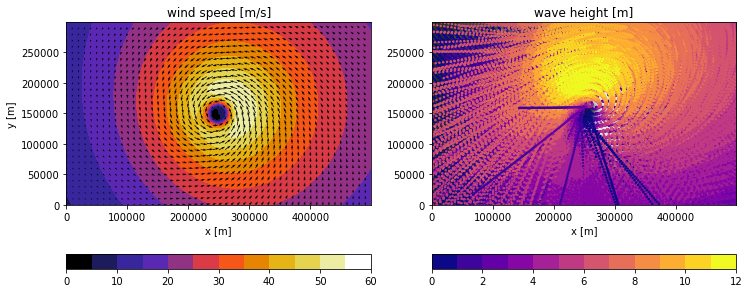

In [7]:
### wind field
v=np.sqrt(vx**2+vy**2)
plt.figure(figsize=(12,6))
cmap = cm.get_cmap('CMRmap', 12)
plt.subplot(1,2,1)
plt.imshow(v,origin='lower',extent=(-np.min(x),np.max(x),-np.min(y),np.max(y)),cmap=cmap,vmin=0,vmax=60)
plt.colorbar(orientation='horizontal')
plt.quiver(x[0::10,0::10],y[0::10,0::10],vx[0::10,0::10],vy[0::10,0::10])
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('wind speed [m/s]')

### wave trains
plt.subplot(1,2,2)
cmap = cm.get_cmap('gray', 12)
cmap2 = cm.get_cmap('plasma', 12)
plt.imshow(v,origin='lower',extent=(-np.min(x),np.max(x),-np.min(y),np.max(y)),cmap=cmap,vmin=0,vmax=60)
plt.scatter(x_wt[0::10,:].ravel(),y_wt[0::10,:].ravel(),c=np.sqrt(e[0::10,:].ravel())*4,cmap=cmap2,s=2,vmin=0,vmax=12)
plt.colorbar(orientation='horizontal')
plt.xlabel('x [m]')
#plt.ylabel('y [m]')
plt.xlim(np.min(x),np.max(x))
plt.ylim(np.min(y),np.max(y))
plt.title('wave height [m]')

plt.savefig(outpath + 'WindAndWaveTrains.png')

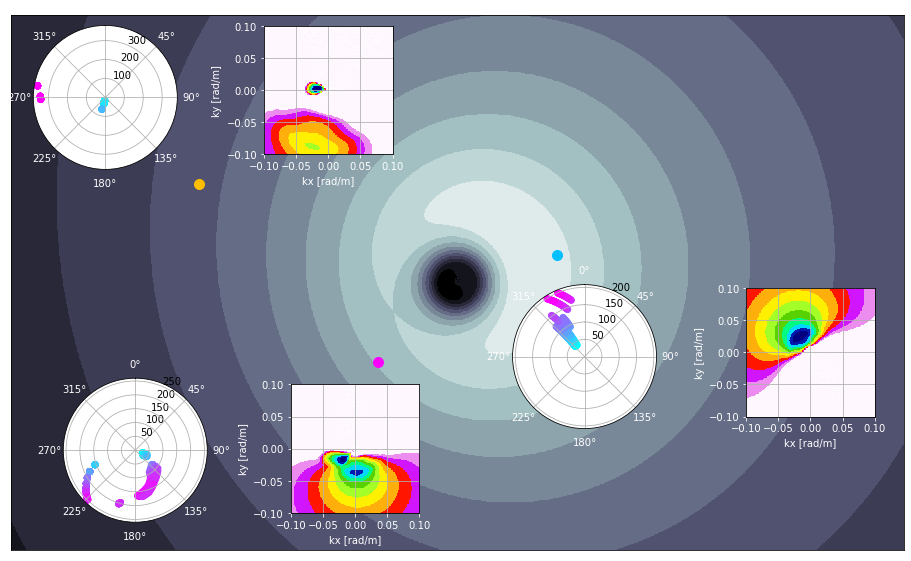

In [8]:
fig=plt.figure(figsize=(16,10))
extent=(np.min(kx),np.max(kx),np.min(ky),np.max(ky))
axes=fig.add_subplot(1,1,1)
cmap = cm.get_cmap('bone', 12)
axes.imshow(v,origin='lower',extent=(-np.min(x),np.max(x),-np.min(y),np.max(y)),cmap=cmap,vmin=0,vmax=60)
#axes.quiver(x[0::5,0::5],y[0::5,0::5],vx[0::5,0::5],vy[0::5,0::5],color=(1,1,1))
axes.set_xticks([])
axes.set_yticks([])

I1=1010
axes.plot(x_b[I1],y_b[I1],'.',markersize=20,color=(1,0.75,0))

cmap2 = cm.get_cmap('gist_ncar_r', 12)
vmin=1E0
vmax=1E4
subpos = [0.28,0.74,0.15,0.15*16/10]
ins = axes.inset_axes(subpos)
#ins.set_xticks([])
#ins.set_yticks([])
ins.tick_params(axis='x', colors='white')
ins.tick_params(axis='y', colors='white')
ins.set_xlabel('kx [rad/m]')
ins.set_ylabel('ky [rad/m]')
ins.xaxis.label.set_color('white')
ins.yaxis.label.set_color('white')
ins.imshow(np.fft.fftshift(np.absolute(S[:,:,I1])),origin='lower',extent=extent,cmap=cmap2,norm=LogNorm(vmin=vmin,vmax=vmax))
ins.set_xlim(-0.1,0.1)
ins.set_ylim(-0.1,0.1)
ins.grid()
subpos = [0.144,0.66,0.125,0.125*16/10]
cmap2 = cm.get_cmap('cool', 12)
ins = fig.add_axes(subpos, polar=True)
I=np.logical_and(np.absolute(x_b[I1]-x_wt_temp) < d_lim,np.absolute(y_b[I1]-y_wt_temp) < d_lim)
#ins.subplot(111)
#plt.polar(3,1)
ins.tick_params(axis='x', colors='white')
#ins.set_xticks([])
#ins.set_yticks([])
ins.scatter(np.radians(phi_p_temp[I]),la_p_temp[I],c=np.sqrt(e_temp[I])*4, cmap=cmap2)
ins.set_theta_direction(-1)
ins.set_theta_zero_location('N')


I1=520
axes.plot(x_b[I1],y_b[I1],'.',markersize=20,color=(1,0,1))

cmap2 = cm.get_cmap('gist_ncar_r', 12)
vmin=1E0
vmax=1E4
subpos = [0.31,0.07,0.15,0.15*16/10]
ins = axes.inset_axes(subpos)
#ins.set_xticks([])
#ins.set_yticks([])
ins.tick_params(axis='x', colors='white')
ins.tick_params(axis='y', colors='white')
ins.set_xlabel('kx [rad/m]')
ins.set_ylabel('ky [rad/m]')
ins.xaxis.label.set_color('white')
ins.yaxis.label.set_color('white')
ins.imshow(np.fft.fftshift(np.absolute(S[:,:,I1])),origin='lower',extent=extent,cmap=cmap2,norm=LogNorm(vmin=vmin,vmax=vmax))
ins.set_xlim(-0.1,0.1)
ins.set_ylim(-0.1,0.1)
ins.grid()
subpos = [0.17,0.17,0.125,0.125*16/10]
cmap2 = cm.get_cmap('cool', 12)
ins = fig.add_axes(subpos, polar=True)
I=np.logical_and(np.absolute(x_b[I1]-x_wt_temp) < d_lim,np.absolute(y_b[I1]-y_wt_temp) < d_lim)
#ins.subplot(111)
#plt.polar(3,1)
ins.tick_params(axis='x', colors='white')
#ins.set_xticks([])
#ins.set_yticks([])
ins.scatter(np.radians(phi_p_temp[I]),la_p_temp[I],c=np.sqrt(e_temp[I])*4, cmap=cmap2)
ins.set_theta_direction(-1)
ins.set_theta_zero_location('N')


I1=830
axes.plot(x_b[I1],y_b[I1],'.',markersize=20,color=(0,0.75,1))

cmap2 = cm.get_cmap('gist_ncar_r', 12)
vmin=1E0
vmax=1E4
subpos = [0.82,0.25,0.15,0.15*16/10]
ins = axes.inset_axes(subpos)
#ins.set_xticks([])
#ins.set_yticks([])
ins.grid()
ins.tick_params(axis='x', colors='white')
ins.tick_params(axis='y', colors='white')
ins.set_xlabel('kx [rad/m]')
ins.set_ylabel('ky [rad/m]')
ins.xaxis.label.set_color('white')
ins.yaxis.label.set_color('white')
ins.imshow(np.fft.fftshift(np.absolute(S[:,:,I1])),origin='lower',extent=extent,cmap=cmap2,norm=LogNorm(vmin=vmin,vmax=vmax))
ins.set_xlim(-0.1,0.1)
ins.set_ylim(-0.1,0.1)
subpos = [0.56,0.30,0.125,0.125*16/10]
cmap2 = cm.get_cmap('cool', 12)
ins = fig.add_axes(subpos, polar=True)
I=np.logical_and(np.absolute(x_b[I1]-x_wt_temp) < d_lim,np.absolute(y_b[I1]-y_wt_temp) < d_lim)
#ins.subplot(111)
#plt.polar(3,1)
ins.tick_params(axis='x', colors='white')
#ins.set_xticks([])
#ins.set_yticks([])
ins.scatter(np.radians(phi_p_temp[I]),la_p_temp[I],c=np.sqrt(e_temp[I])*4, cmap=cmap2)
ins.set_theta_direction(-1)
ins.set_theta_zero_location('N')


plt.savefig(outpath + 'WaveTrainsAndWaveSpectra.png')

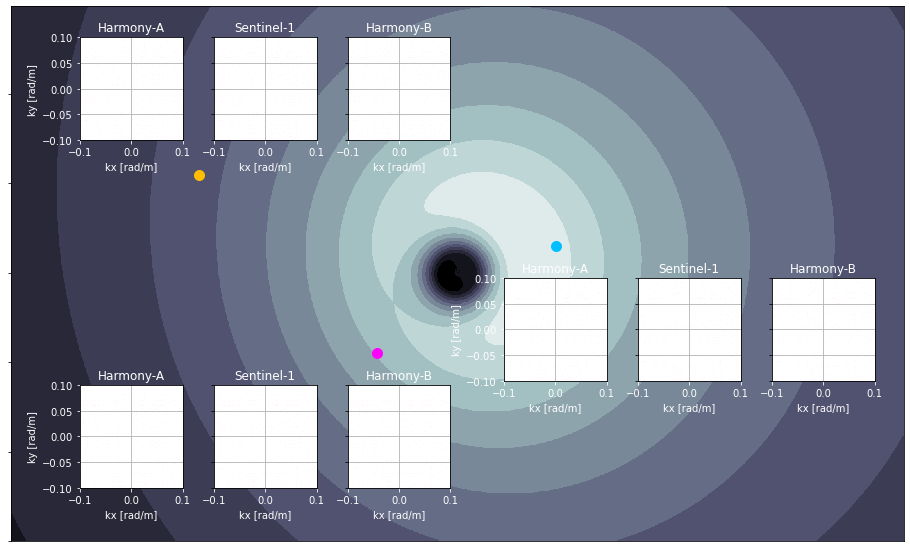

In [9]:
fig=plt.figure(figsize=(16,10))
extent=(np.min(kx),np.max(kx),np.min(ky),np.max(ky))
axes=fig.add_subplot(1,1,1)
cmap = cm.get_cmap('bone', 12)
axes.imshow(v,origin='lower',extent=(-np.min(x),np.max(x),-np.min(y),np.max(y)),cmap=cmap,vmin=0,vmax=60)
#axes.quiver(x[0::5,0::5],y[0::5,0::5],vx[0::5,0::5],vy[0::5,0::5],color=(1,1,1))
axes.set_xticks([])
axes.set_yticklabels([])

I1=1010
axes.plot(x_b[I1],y_b[I1],'.',markersize=20,color=(1,0.75,0))

cmap2 = cm.get_cmap('gist_ncar_r', 12)
vmin=1E0
vmax=1E4
subpos = [0.075,0.75,0.12,0.12*16/10]
ins = axes.inset_axes(subpos)
ins.set_title('Harmony-A',color= 'white')
ins.tick_params(axis='x', colors='white')
ins.tick_params(axis='y', colors='white')
ins.set_xlabel('kx [rad/m]')
ins.set_ylabel('ky [rad/m]')
ins.xaxis.label.set_color('white')
ins.yaxis.label.set_color('white')
ins.imshow(np.fft.fftshift(np.absolute(Ph1[:,:,I1])),origin='lower',extent=extent,cmap=cmap2,norm=LogNorm(vmin=vmin,vmax=vmax))
ins.set_xlim(-0.1,0.1)
ins.set_ylim(-0.1,0.1)
ins.grid()
subpos = [0.225,0.75,0.12,0.12*16/10]
ins = axes.inset_axes(subpos)
ins.set_title('Sentinel-1',color= 'white')
ins.tick_params(axis='x', colors='white')
ins.set_xlabel('kx [rad/m]')
ins.set_yticklabels([])
ins.xaxis.label.set_color('white')
ins.imshow(np.fft.fftshift(np.absolute(Pm[:,:,I1])),origin='lower',extent=extent,cmap=cmap2,norm=LogNorm(vmin=vmin,vmax=vmax))
ins.set_xlim(-0.1,0.1)
ins.set_ylim(-0.1,0.1)
ins.grid()
subpos = [0.375,0.75,0.12,0.12*16/10]
ins = axes.inset_axes(subpos)
ins.set_title('Harmony-B',color= 'white')
ins.tick_params(axis='x', colors='white')
ins.set_yticklabels([])
ins.set_xlabel('kx [rad/m]')
ins.xaxis.label.set_color('white')
ins.imshow(np.fft.fftshift(np.absolute(Ph2[:,:,I1])),origin='lower',extent=extent,cmap=cmap2,norm=LogNorm(vmin=vmin,vmax=vmax))
ins.set_xlim(-0.1,0.1)
ins.set_ylim(-0.1,0.1)
ins.grid()


I1=520
axes.plot(x_b[I1],y_b[I1],'.',markersize=20,color=(1,0,1))

cmap2 = cm.get_cmap('gist_ncar_r', 12)
vmin=1E0
vmax=1E4
subpos = [0.075,0.1,0.12,0.12*16/10]
ins = axes.inset_axes(subpos)
ins.set_title('Harmony-A',color= 'white')
ins.tick_params(axis='x', colors='white')
ins.tick_params(axis='y', colors='white')
ins.set_xlabel('kx [rad/m]')
ins.set_ylabel('ky [rad/m]')
ins.xaxis.label.set_color('white')
ins.yaxis.label.set_color('white')
ins.imshow(np.fft.fftshift(np.absolute(Ph1[:,:,I1])),origin='lower',extent=extent,cmap=cmap2,norm=LogNorm(vmin=vmin,vmax=vmax))
ins.set_xlim(-0.1,0.1)
ins.set_ylim(-0.1,0.1)
ins.grid()
subpos = [0.225,0.1,0.12,0.12*16/10]
ins = axes.inset_axes(subpos)
ins.set_title('Sentinel-1',color= 'white')
ins.tick_params(axis='x', colors='white')
ins.set_xlabel('kx [rad/m]')
ins.set_yticklabels([])
ins.xaxis.label.set_color('white')
ins.imshow(np.fft.fftshift(np.absolute(Pm[:,:,I1])),origin='lower',extent=extent,cmap=cmap2,norm=LogNorm(vmin=vmin,vmax=vmax))
ins.set_xlim(-0.1,0.1)
ins.set_ylim(-0.1,0.1)
ins.grid()
subpos = [0.375,0.1,0.12,0.12*16/10]
ins = axes.inset_axes(subpos)
ins.set_title('Harmony-B',color= 'white')
ins.tick_params(axis='x', colors='white')
ins.set_xlabel('kx [rad/m]')
ins.set_yticklabels([])
ins.xaxis.label.set_color('white')
ins.imshow(np.fft.fftshift(np.absolute(Ph2[:,:,I1])),origin='lower',extent=extent,cmap=cmap2,norm=LogNorm(vmin=vmin,vmax=vmax))
ins.set_xlim(-0.1,0.1)
ins.set_ylim(-0.1,0.1)
ins.grid()

I1=830
axes.plot(x_b[I1],y_b[I1],'.',markersize=20,color=(0,0.75,1))

cmap2 = cm.get_cmap('gist_ncar_r', 12)
vmin=1E0
vmax=1E4
subpos = [0.55,0.3,0.12,0.12*16/10]
ins = axes.inset_axes(subpos)
ins.set_title('Harmony-A',color= 'white')
ins.tick_params(axis='x', colors='white')
ins.tick_params(axis='y', colors='white')
ins.set_xlabel('kx [rad/m]')
ins.set_ylabel('ky [rad/m]')
ins.xaxis.label.set_color('white')
ins.yaxis.label.set_color('white')
ins.imshow(np.fft.fftshift(np.absolute(Ph1[:,:,I1])),origin='lower',extent=extent,cmap=cmap2,norm=LogNorm(vmin=vmin,vmax=vmax))
ins.set_xlim(-0.1,0.1)
ins.set_ylim(-0.1,0.1)
ins.grid()
subpos = [0.70,0.3,0.12,0.12*16/10]
ins = axes.inset_axes(subpos)
ins.set_title('Sentinel-1',color= 'white')
ins.tick_params(axis='x', colors='white')
ins.set_xlabel('kx [rad/m]')
ins.set_yticklabels([])
ins.xaxis.label.set_color('white')
ins.imshow(np.fft.fftshift(np.absolute(Pm[:,:,I1])),origin='lower',extent=extent,cmap=cmap2,norm=LogNorm(vmin=vmin,vmax=vmax))
ins.set_xlim(-0.1,0.1)
ins.set_ylim(-0.1,0.1)
ins.grid()
subpos = [0.85,0.3,0.12,0.12*16/10]
ins = axes.inset_axes(subpos)
ins.set_title('Harmony-B',color= 'white')
ins.tick_params(axis='x', colors='white')
ins.set_xlabel('kx [rad/m]')
ins.xaxis.label.set_color('white')
ins.set_yticklabels([])
ins.imshow(np.fft.fftshift(np.absolute(Ph2[:,:,I1])),origin='lower',extent=extent,cmap=cmap2,norm=LogNorm(vmin=vmin,vmax=vmax))
ins.set_xlim(-0.1,0.1)
ins.set_ylim(-0.1,0.1)
ins.grid()

plt.savefig(outpath + 'SARspectra.png')

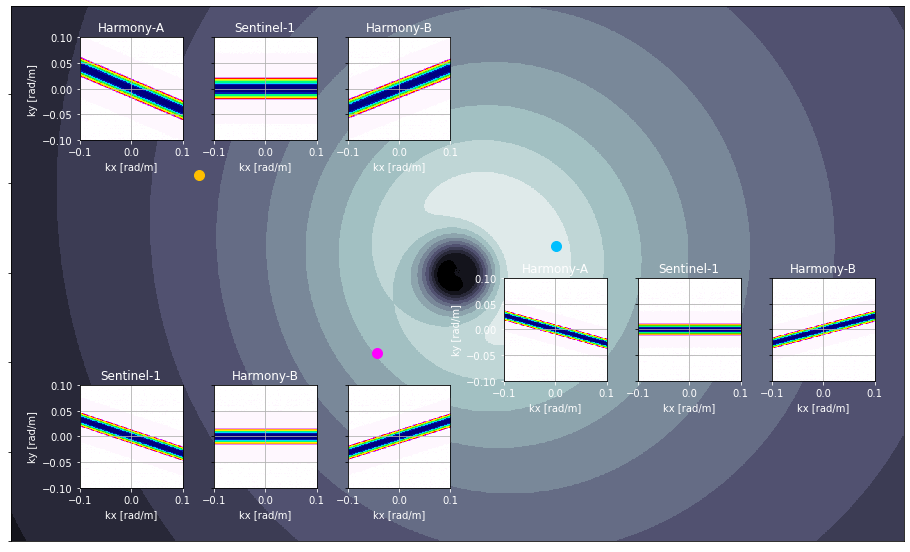

In [10]:
fig=plt.figure(figsize=(16,10))
extent=(np.min(kx),np.max(kx),np.min(ky),np.max(ky))
axes=fig.add_subplot(1,1,1)
cmap = cm.get_cmap('bone', 12)
axes.imshow(v,origin='lower',extent=(-np.min(x),np.max(x),-np.min(y),np.max(y)),cmap=cmap,vmin=0,vmax=60)
#axes.quiver(x[0::5,0::5],y[0::5,0::5],vx[0::5,0::5],vy[0::5,0::5],color=(1,1,1))
axes.set_xticks([])
axes.set_yticklabels([])

I1=1010
axes.plot(x_b[I1],y_b[I1],'.',markersize=20,color=(1,0.75,0))

cmap2 = cm.get_cmap('gist_ncar_r', 12)
vmin=1E-2
vmax=1E0
subpos = [0.075,0.75,0.12,0.12*16/10]
ins = axes.inset_axes(subpos)
ins.set_title('Harmony-A',color= 'white')
ins.tick_params(axis='x', colors='white')
ins.tick_params(axis='y', colors='white')
ins.set_xlabel('kx [rad/m]')
ins.set_ylabel('ky [rad/m]')
ins.xaxis.label.set_color('white')
ins.yaxis.label.set_color('white')
ins.imshow(np.fft.fftshift(np.absolute(Ch1[:,:,I1])),origin='lower',extent=extent,cmap=cmap2,norm=LogNorm(vmin=vmin,vmax=vmax))
ins.set_xlim(-0.1,0.1)
ins.set_ylim(-0.1,0.1)
ins.grid()
subpos = [0.225,0.75,0.12,0.12*16/10]
ins = axes.inset_axes(subpos)
ins.set_title('Sentinel-1',color= 'white')
ins.tick_params(axis='x', colors='white')
ins.set_xlabel('kx [rad/m]')
ins.set_yticklabels([])
ins.xaxis.label.set_color('white')
ins.imshow(np.fft.fftshift(np.absolute(Cm[:,:,I1])),origin='lower',extent=extent,cmap=cmap2,norm=LogNorm(vmin=vmin,vmax=vmax))
ins.set_xlim(-0.1,0.1)
ins.set_ylim(-0.1,0.1)
ins.grid()
subpos = [0.375,0.75,0.12,0.12*16/10]
ins = axes.inset_axes(subpos)
ins.set_title('Harmony-B',color= 'white')
ins.tick_params(axis='x', colors='white')
ins.set_yticklabels([])
ins.set_xlabel('kx [rad/m]')
ins.xaxis.label.set_color('white')
ins.imshow(np.fft.fftshift(np.absolute(Ch2[:,:,I1])),origin='lower',extent=extent,cmap=cmap2,norm=LogNorm(vmin=vmin,vmax=vmax))
ins.set_xlim(-0.1,0.1)
ins.set_ylim(-0.1,0.1)
ins.grid()


I1=520
axes.plot(x_b[I1],y_b[I1],'.',markersize=20,color=(1,0,1))

cmap2 = cm.get_cmap('gist_ncar_r', 12)
vmin=1E-2
vmax=1E0
subpos = [0.075,0.1,0.12,0.12*16/10]
ins = axes.inset_axes(subpos)
ins.set_title('Harmony-A',color= 'white')
ins.tick_params(axis='x', colors='white')
ins.tick_params(axis='y', colors='white')
ins.set_xlabel('kx [rad/m]')
ins.set_ylabel('ky [rad/m]')
ins.xaxis.label.set_color('white')
ins.yaxis.label.set_color('white')
ins.imshow(np.fft.fftshift(np.absolute(Ch1[:,:,I1])),origin='lower',extent=extent,cmap=cmap2,norm=LogNorm(vmin=vmin,vmax=vmax))
ins.set_xlim(-0.1,0.1)
ins.set_ylim(-0.1,0.1)
ins.grid()
subpos = [0.225,0.1,0.12,0.12*16/10]
ins.set_title('Sentinel-1',color= 'white')
ins = axes.inset_axes(subpos)
ins.tick_params(axis='x', colors='white')
ins.set_xlabel('kx [rad/m]')
ins.set_yticklabels([])
ins.xaxis.label.set_color('white')
ins.imshow(np.fft.fftshift(np.absolute(Cm[:,:,I1])),origin='lower',extent=extent,cmap=cmap2,norm=LogNorm(vmin=vmin,vmax=vmax))
ins.set_xlim(-0.1,0.1)
ins.set_ylim(-0.1,0.1)
ins.grid()
subpos = [0.375,0.1,0.12,0.12*16/10]
ins.set_title('Harmony-B',color= 'white')
ins = axes.inset_axes(subpos)
ins.tick_params(axis='x', colors='white')
ins.set_xlabel('kx [rad/m]')
ins.set_yticklabels([])
ins.xaxis.label.set_color('white')
ins.imshow(np.fft.fftshift(np.absolute(Ch2[:,:,I1])),origin='lower',extent=extent,cmap=cmap2,norm=LogNorm(vmin=vmin,vmax=vmax))
ins.set_xlim(-0.1,0.1)
ins.set_ylim(-0.1,0.1)
ins.grid()

I1=830
axes.plot(x_b[I1],y_b[I1],'.',markersize=20,color=(0,0.75,1))

cmap2 = cm.get_cmap('gist_ncar_r', 12)
vmin=1E-2
vmax=1E0
subpos = [0.55,0.3,0.12,0.12*16/10]
ins = axes.inset_axes(subpos)
ins.set_title('Harmony-A',color= 'white')
ins.tick_params(axis='x', colors='white')
ins.tick_params(axis='y', colors='white')
ins.set_xlabel('kx [rad/m]')
ins.set_ylabel('ky [rad/m]')
ins.xaxis.label.set_color('white')
ins.yaxis.label.set_color('white')
ins.imshow(np.fft.fftshift(np.absolute(Ch1[:,:,I1])),origin='lower',extent=extent,cmap=cmap2,norm=LogNorm(vmin=vmin,vmax=vmax))
ins.set_xlim(-0.1,0.1)
ins.set_ylim(-0.1,0.1)
ins.grid()
subpos = [0.70,0.3,0.12,0.12*16/10]
ins = axes.inset_axes(subpos)
ins.set_title('Sentinel-1',color= 'white')
ins.tick_params(axis='x', colors='white')
ins.set_xlabel('kx [rad/m]')
ins.set_yticklabels([])
ins.xaxis.label.set_color('white')
ins.imshow(np.fft.fftshift(np.absolute(Cm[:,:,I1])),origin='lower',extent=extent,cmap=cmap2,norm=LogNorm(vmin=vmin,vmax=vmax))
ins.set_xlim(-0.1,0.1)
ins.set_ylim(-0.1,0.1)
ins.grid()
subpos = [0.85,0.3,0.12,0.12*16/10]
ins = axes.inset_axes(subpos)
ins.set_title('Harmony-B',color= 'white')
ins.tick_params(axis='x', colors='white')
ins.set_xlabel('kx [rad/m]')
ins.xaxis.label.set_color('white')
ins.set_yticklabels([])
ins.imshow(np.fft.fftshift(np.absolute(Ch2[:,:,I1])),origin='lower',extent=extent,cmap=cmap2,norm=LogNorm(vmin=vmin,vmax=vmax))
ins.set_xlim(-0.1,0.1)
ins.set_ylim(-0.1,0.1)
ins.grid()

plt.savefig(outpath + 'Cutoffs.png')

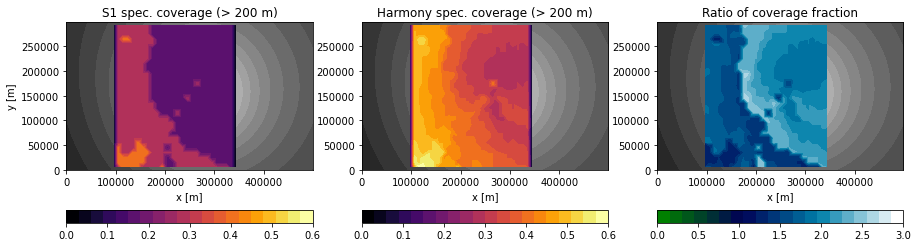

In [11]:
### wind field
cmap2 = cm.get_cmap('gray', 20)
I=frac_S1 < 1
frac_int1=interpolate.griddata((x_b[I],y_b[I]),frac_S1[I],(x,y),'linear')
frac_int1[frac_int1==0]=np.NaN
plt.figure(figsize=(15,5))
cmap = cm.get_cmap('inferno', 20)
plt.subplot(1,3,1)
plt.imshow(v,origin='lower',extent=(-np.min(x),np.max(x),-np.min(y),np.max(y)),cmap=cmap2,vmin=0,vmax=60)
plt.imshow(frac_int1,origin='lower',extent=(-np.min(x),np.max(x),-np.min(y),np.max(y)),cmap=cmap,vmin=0,vmax=0.6)
plt.colorbar(orientation='horizontal')
#plt.quiver(x[0::10,0::10],y[0::10,0::10],vx[0::10,0::10],vy[0::10,0::10])
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('S1 spec. coverage (> 200 m)')

### cut-off fraction
I=frac_H < 1
frac_int2=interpolate.griddata((x_b[I],y_b[I]),frac_H[I],(x,y),'linear')
frac_int2[frac_int2==0]=np.NaN
plt.subplot(1,3,2)
plt.imshow(v,origin='lower',extent=(-np.min(x),np.max(x),-np.min(y),np.max(y)),cmap=cmap2,vmin=0,vmax=60)
plt.imshow(frac_int2,origin='lower',extent=(-np.min(x),np.max(x),-np.min(y),np.max(y)),cmap=cmap,vmin=0,vmax=0.6)
#plt.scatter(x_wt[0::10,:].ravel(),y_wt[0::10,:].ravel(),c=np.sqrt(e[0::10,:].ravel())*4,cmap=cmap2,s=2,vmin=0,vmax=12)
plt.colorbar(orientation='horizontal')
plt.xlabel('x [m]')
#plt.ylabel('y [m]')
plt.xlim(np.min(x),np.max(x))
plt.ylim(np.min(y),np.max(y))
plt.title('Harmony spec. coverage (> 200 m)')

plt.subplot(1,3,3)
cmap = cm.get_cmap('ocean', 20)
plt.imshow(v,origin='lower',extent=(-np.min(x),np.max(x),-np.min(y),np.max(y)),cmap=cmap2,vmin=0,vmax=60)
plt.imshow(frac_int2/frac_int1,origin='lower',extent=(-np.min(x),np.max(x),-np.min(y),np.max(y)),cmap=cmap,vmin=0,vmax=3)
#plt.scatter(x_wt[0::10,:].ravel(),y_wt[0::10,:].ravel(),c=np.sqrt(e[0::10,:].ravel())*4,cmap=cmap2,s=2,vmin=0,vmax=12)
plt.colorbar(orientation='horizontal')
plt.xlabel('x [m]')
#plt.ylabel('y [m]')
plt.xlim(np.min(x),np.max(x))
plt.ylim(np.min(y),np.max(y))
plt.title('Ratio of coverage fraction')

plt.savefig(outpath + 'Coverage.png')

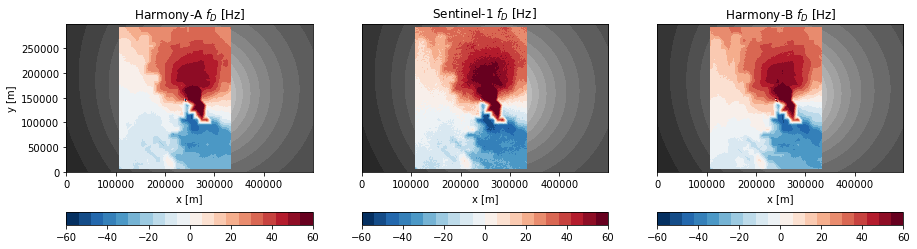

In [12]:
### Doppler
vmin, vmax = -60,60
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
cmap = cm.get_cmap('RdBu_r', 20)
cmap2 = cm.get_cmap('gray', 20)
plt.imshow(v,origin='lower',extent=(-np.min(x),np.max(x),-np.min(y),np.max(y)),cmap=cmap2,vmin=0,vmax=60)
plt.imshow(Doppler_int[:,:,1],origin='lower',extent=(-np.min(x),np.max(x),-np.min(y),np.max(y)),cmap=cmap,vmin=vmin,vmax=vmax)
plt.colorbar(orientation='horizontal')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.xlim(np.min(x),np.max(x))
plt.ylim(np.min(y),np.max(y))
plt.title('Harmony-A $f_D$ [Hz]')

plt.subplot(1,3,2)
plt.imshow(v,origin='lower',extent=(-np.min(x),np.max(x),-np.min(y),np.max(y)),cmap=cmap2,vmin=0,vmax=60)
plt.imshow(Doppler_int[:,:,0],origin='lower',extent=(-np.min(x),np.max(x),-np.min(y),np.max(y)),cmap=cmap,vmin=vmin,vmax=vmax)
plt.colorbar(orientation='horizontal')
plt.xlabel('x [m]')
plt.yticks([])
plt.xlim(np.min(x),np.max(x))
plt.ylim(np.min(y),np.max(y))
plt.title('Sentinel-1 $f_D$ [Hz]')

plt.subplot(1,3,3)
plt.imshow(v,origin='lower',extent=(-np.min(x),np.max(x),-np.min(y),np.max(y)),cmap=cmap2,vmin=0,vmax=60)
plt.imshow(Doppler_int[:,:,2],origin='lower',extent=(-np.min(x),np.max(x),-np.min(y),np.max(y)),cmap=cmap,vmin=vmin,vmax=vmax)
plt.colorbar(orientation='horizontal')
plt.xlabel('x [m]')
plt.yticks([])
plt.xlim(np.min(x),np.max(x))
plt.ylim(np.min(y),np.max(y))
plt.title('Harmony-B $f_D$ [Hz]')
plt.savefig(outpath + 'Doppler.png')

/var/folders/qc/f0tlt3vs1zb1p6qd5vr630vr0000gn/T/ipykernel_14507/125239169.py:6: RuntimeWarning: invalid value encountered in log10
  plt.imshow(10*np.log10(sigma[:,:,1]),origin='lower',extent=(-np.min(x),np.max(x),-np.min(y),np.max(y)),cmap=cmap,vmin=-15,vmax=-5)
/var/folders/qc/f0tlt3vs1zb1p6qd5vr630vr0000gn/T/ipykernel_14507/125239169.py:30: RuntimeWarning: invalid value encountered in log10
  plt.imshow(10*np.log10(sigma[:,:,2]),origin='lower',extent=(-np.min(x),np.max(x),-np.min(y),np.max(y)),cmap=cmap,vmin=-15,vmax=-5)


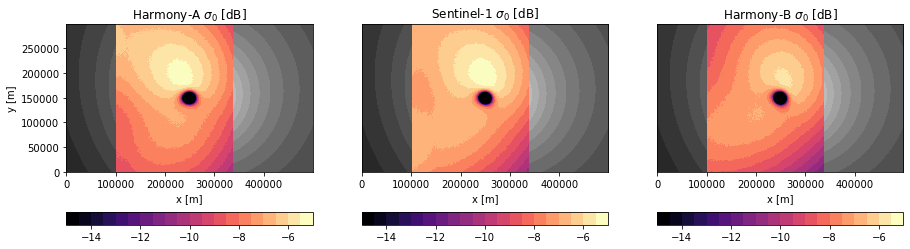

In [13]:
### backscatter
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
cmap = cm.get_cmap('magma', 20)
plt.imshow(v,origin='lower',extent=(-np.min(x),np.max(x),-np.min(y),np.max(y)),cmap=cmap2,vmin=0,vmax=60)
plt.imshow(10*np.log10(sigma[:,:,1]),origin='lower',extent=(-np.min(x),np.max(x),-np.min(y),np.max(y)),cmap=cmap,vmin=-15,vmax=-5)
plt.colorbar(orientation='horizontal')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.xlim(np.min(x),np.max(x))
plt.ylim(np.min(y),np.max(y))
plt.title('Harmony-A $\sigma_0$ [dB]')
#plt.yticks([])

### backscatter
plt.subplot(1,3,2)
plt.imshow(v,origin='lower',extent=(-np.min(x),np.max(x),-np.min(y),np.max(y)),cmap=cmap2,vmin=0,vmax=60)
plt.imshow(10*np.log10(sigma[:,:,0]),origin='lower',extent=(-np.min(x),np.max(x),-np.min(y),np.max(y)),cmap=cmap,vmin=-15,vmax=-5)
plt.colorbar(orientation='horizontal')
plt.xlabel('x [m]')
#plt.ylabel('y [m]')
plt.xlim(np.min(x),np.max(x))
plt.ylim(np.min(y),np.max(y))
plt.title('Sentinel-1 $\sigma_0$ [dB]')
plt.yticks([])

### backscatter
plt.subplot(1,3,3)
plt.imshow(v,origin='lower',extent=(-np.min(x),np.max(x),-np.min(y),np.max(y)),cmap=cmap2,vmin=0,vmax=60)
plt.imshow(10*np.log10(sigma[:,:,2]),origin='lower',extent=(-np.min(x),np.max(x),-np.min(y),np.max(y)),cmap=cmap,vmin=-15,vmax=-5)
plt.colorbar(orientation='horizontal')
plt.xlabel('x [m]')
#plt.ylabel('y [m]')
plt.xlim(np.min(x),np.max(x))
plt.ylim(np.min(y),np.max(y))
plt.title('Harmony-B $\sigma_0$ [dB]')
plt.yticks([])
plt.savefig(outpath + 'Scatter.png')

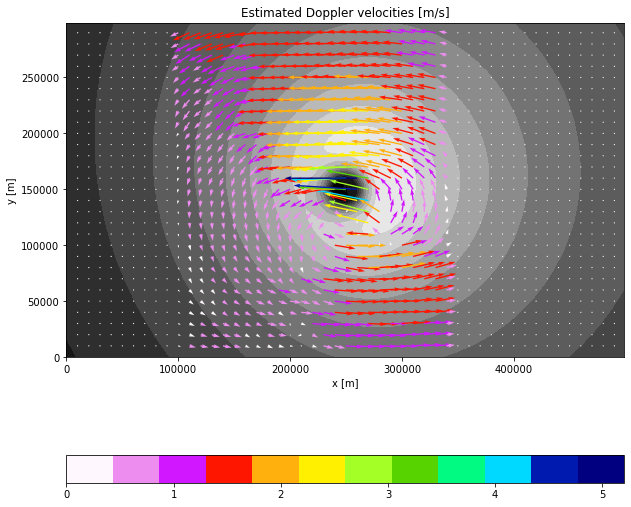

In [14]:
la_r=0.056
vx_int=interpolate.griddata((x_b,y_b),vx_est,(x,y),'linear')
vy_int=interpolate.griddata((x_b,y_b),vy_est,(x,y),'linear')
v_int=np.sqrt(vx_int**2+vy_int**2)
cmap = cm.get_cmap('gray', 12)
cmap2 = cm.get_cmap('gist_ncar_r', 12)
plt.figure(figsize=(10,12))
plt.imshow(v,origin='lower',extent=(-np.min(x),np.max(x),-np.min(y),np.max(y)),cmap=cmap,vmin=0,vmax=60)
#plt.quiver(x[0::10,0::10],y[0::10,0::10],vx[0::10,0::10],vy[0::10,0::10])
plt.quiver(x[0::10,0::10],y[0::10,0::10],vx_int[0::10,0::10],vy_int[0::10,0::10],v_int[0::10,0::10],cmap=cmap2)
plt.colorbar(orientation='horizontal')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Estimated Doppler velocities [m/s]')
plt.savefig(outpath + 'Doppler_velocities.png')

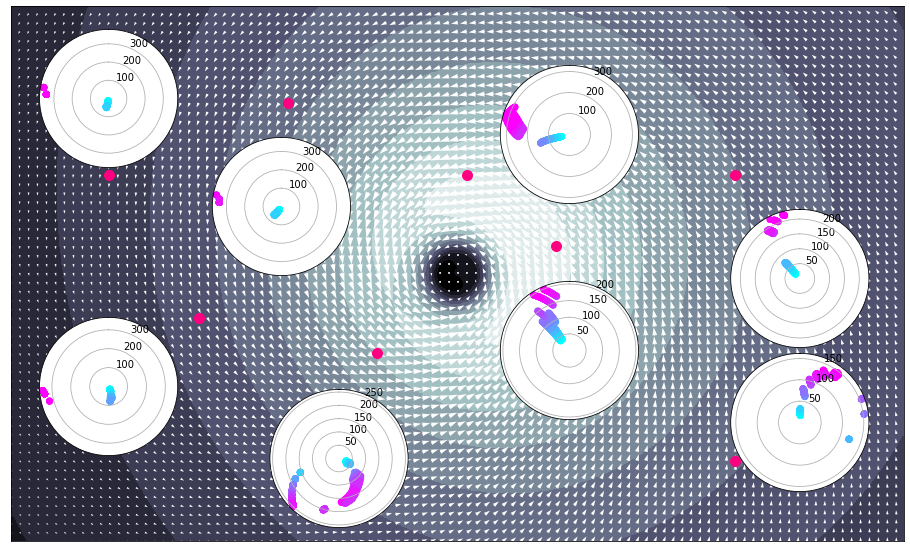

In [15]:
fig=plt.figure(figsize=(16,10))
extent=(np.min(kx),np.max(kx),np.min(ky),np.max(ky))
axes=fig.add_subplot(1,1,1)
cmap = cm.get_cmap('bone', 12)
axes.imshow(v,origin='lower',extent=(-np.min(x),np.max(x),-np.min(y),np.max(y)),cmap=cmap,vmin=0,vmax=60)
axes.quiver(x[0::5,0::5],y[0::5,0::5],vx[0::5,0::5],vy[0::5,0::5],color=(1,1,1))
axes.set_xticks([])
axes.set_yticks([])

I1=1005
axes.plot(x_b[I1],y_b[I1],'.',markersize=20,color=(1,0,0.5))

cmap2 = cm.get_cmap('cool', 12)
vmin=1E0
vmax=1E4
d_lim=10E3
subpos = [0.15,0.65,0.12,0.12*16/10]
ins = fig.add_axes(subpos, polar=True)
I=np.logical_and(np.absolute(x_b[I1]-x_wt_temp) < d_lim,np.absolute(y_b[I1]-y_wt_temp) < d_lim)
#ins.subplot(111)
#plt.polar(3,1)
ins.set_xticks([])
#ins.set_yticks([])
ins.scatter(np.radians(phi_p_temp[I]),la_p_temp[I],c=np.sqrt(e_temp[I])*4, cmap=cmap2)
ins.set_theta_direction(-1)
ins.set_theta_zero_location('N')
#ins.set_xlim(-0.1,0.1)
#ins.set_ylim(-0.1,0.1)

I2=520
axes.plot(x_b[I2],y_b[I2],'.',markersize=20,color=(1,0,0.5))

d_lim=10E3
subpos = [0.35,0.15,0.12,0.12*16/10]
ins = fig.add_axes(subpos, polar=True)
I=np.logical_and(np.absolute(x_b[I2]-x_wt_temp) < d_lim,np.absolute(y_b[I2]-y_wt_temp) < d_lim)
#ins.subplot(111)
#plt.polar(3,1)
ins.set_xticks([])
#ins.set_yticks([])
ins.scatter(np.radians(phi_p_temp[I]),la_p_temp[I],c=np.sqrt(e_temp[I])*4, cmap=cmap2)
ins.set_theta_direction(-1)
ins.set_theta_zero_location('N')
#ins.set_xlim(-0.1,0.1)
#ins.set_ylim(-0.1,0.1)

I3=830
axes.plot(x_b[I3],y_b[I3],'.',markersize=20,color=(1,0,0.5))

d_lim=10E3
subpos = [0.55,0.30,0.12,0.12*16/10]
ins = fig.add_axes(subpos, polar=True)
I=np.logical_and(np.absolute(x_b[I3]-x_wt_temp) < d_lim,np.absolute(y_b[I3]-y_wt_temp) < d_lim)
#ins.subplot(111)
#plt.polar(3,1)
ins.set_xticks([])
#ins.set_yticks([])
ins.scatter(np.radians(phi_p_temp[I]),la_p_temp[I],c=np.sqrt(e_temp[I])*4, cmap=cmap2)
ins.set_theta_direction(-1)
ins.set_theta_zero_location('N')
#ins.set_xlim(-0.1,0.1)
#ins.set_ylim(-0.1,0.1)

I4=610
axes.plot(x_b[I4],y_b[I4],'.',markersize=20,color=(1,0,0.5))

d_lim=10E3
subpos = [0.15,0.25,0.12,0.12*16/10]
ins = fig.add_axes(subpos, polar=True)
I=np.logical_and(np.absolute(x_b[I4]-x_wt_temp) < d_lim,np.absolute(y_b[I4]-y_wt_temp) < d_lim)
#ins.subplot(111)
#plt.polar(3,1)
ins.set_xticks([])
#ins.set_yticks([])
ins.scatter(np.radians(phi_p_temp[I]),la_p_temp[I],c=np.sqrt(e_temp[I])*4, cmap=cmap2)
ins.set_theta_direction(-1)
ins.set_theta_zero_location('N')
#ins.set_xlim(-0.1,0.1)
#ins.set_ylim(-0.1,0.1)


I5=1025
axes.plot(x_b[I5],y_b[I5],'.',markersize=20,color=(1,0,0.5))

d_lim=10E3
subpos = [0.55,0.60,0.12,0.12*16/10]
ins = fig.add_axes(subpos, polar=True)
I=np.logical_and(np.absolute(x_b[I5]-x_wt_temp) < d_lim,np.absolute(y_b[I5]-y_wt_temp) < d_lim)
#ins.subplot(111)
#plt.polar(3,1)
ins.set_xticks([])
#ins.set_yticks([])
ins.scatter(np.radians(phi_p_temp[I]),la_p_temp[I],c=np.sqrt(e_temp[I])*4, cmap=cmap2)
ins.set_theta_direction(-1)
ins.set_theta_zero_location('N')
#ins.set_xlim(-0.1,0.1)
#ins.set_ylim(-0.1,0.1)

I6=1040
axes.plot(x_b[I6],y_b[I6],'.',markersize=20,color=(1,0,0.5))

d_lim=10E3
subpos = [0.75,0.40,0.12,0.12*16/10]
ins = fig.add_axes(subpos, polar=True)
I=np.logical_and(np.absolute(x_b[I6]-x_wt_temp) < d_lim,np.absolute(y_b[I6]-y_wt_temp) < d_lim)
#ins.subplot(111)
#plt.polar(3,1)
ins.set_xticks([])
#ins.set_yticks([])
ins.scatter(np.radians(phi_p_temp[I]),la_p_temp[I],c=np.sqrt(e_temp[I])*4, cmap=cmap2)
ins.set_theta_direction(-1)
ins.set_theta_zero_location('N')
#ins.set_xlim(-0.1,0.1)
#ins.set_ylim(-0.1,0.1)

I7=240
axes.plot(x_b[I7],y_b[I7],'.',markersize=20,color=(1,0,0.5))

d_lim=10E3
subpos = [0.75,0.20,0.12,0.12*16/10]
ins = fig.add_axes(subpos, polar=True)
I=np.logical_and(np.absolute(x_b[I7]-x_wt_temp) < d_lim,np.absolute(y_b[I7]-y_wt_temp) < d_lim)
#ins.subplot(111)
#plt.polar(3,1)
ins.set_xticks([])
#ins.set_yticks([])
ins.scatter(np.radians(phi_p_temp[I]),la_p_temp[I],c=np.sqrt(e_temp[I])*4, cmap=cmap2)
ins.set_theta_direction(-1)
ins.set_theta_zero_location('N')
#ins.set_xlim(-0.1,0.1)
#ins.set_ylim(-0.1,0.1)


I8=1215
axes.plot(x_b[I8],y_b[I8],'.',markersize=20,color=(1,0,0.5))

d_lim=10E3
subpos = [0.30,0.50,0.12,0.12*16/10]
ins = fig.add_axes(subpos, polar=True)
I=np.logical_and(np.absolute(x_b[I8]-x_wt_temp) < d_lim,np.absolute(y_b[I8]-y_wt_temp) < d_lim)
#ins.subplot(111)
#plt.polar(3,1)
ins.set_xticks([])
#ins.set_yticks([])
ins.scatter(np.radians(phi_p_temp[I]),la_p_temp[I],c=np.sqrt(e_temp[I])*4, cmap=cmap2)
ins.set_theta_direction(-1)
ins.set_theta_zero_location('N')
#ins.set_xlim(-0.1,0.1)
#ins.set_ylim(-0.1,0.1)

plt.savefig(outpath + 'WaveTrains.png')

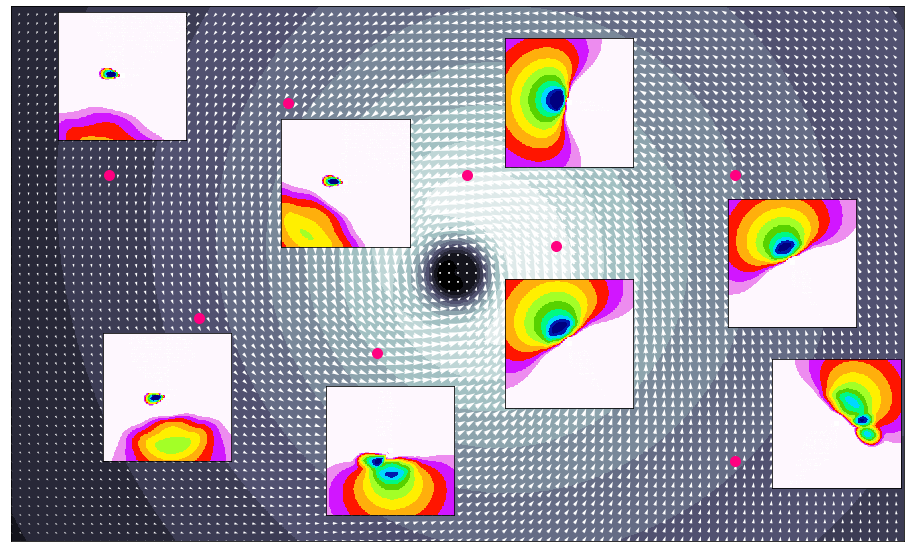

In [16]:
fig=plt.figure(figsize=(16,10))
extent=(np.min(kx),np.max(kx),np.min(ky),np.max(ky))
axes=fig.add_subplot(1,1,1)
cmap = cm.get_cmap('bone', 12)
axes.imshow(v,origin='lower',extent=(-np.min(x),np.max(x),-np.min(y),np.max(y)),cmap=cmap,vmin=0,vmax=60)
axes.quiver(x[0::5,0::5],y[0::5,0::5],vx[0::5,0::5],vy[0::5,0::5],color=(1,1,1))
axes.set_xticks([])
axes.set_yticks([])

I1=1005
axes.plot(x_b[I1],y_b[I1],'.',markersize=20,color=(1,0,0.5))

cmap2 = cm.get_cmap('gist_ncar_r', 12)
vmin=1E0
vmax=1E4
subpos = [0.05,0.75,0.15,0.15*16/10]
ins = axes.inset_axes(subpos)
ins.set_xticks([])
ins.set_yticks([])
ins.imshow(np.fft.fftshift(np.absolute(S[:,:,I1])),origin='lower',extent=extent,cmap=cmap2,norm=LogNorm(vmin=vmin,vmax=vmax))
ins.set_xlim(-0.1,0.1)
ins.set_ylim(-0.1,0.1)

I1=520
axes.plot(x_b[I1],y_b[I1],'.',markersize=20,color=(1,0,0.5))

cmap2 = cm.get_cmap('gist_ncar_r', 12)
vmin=1E0
vmax=1E4
subpos = [0.35,0.05,0.15,0.15*16/10]
ins = axes.inset_axes(subpos)
ins.set_xticks([])
ins.set_yticks([])
ins.imshow(np.fft.fftshift(np.absolute(S[:,:,I1])),origin='lower',extent=extent,cmap=cmap2,norm=LogNorm(vmin=vmin,vmax=vmax))
ins.set_xlim(-0.1,0.1)
ins.set_ylim(-0.1,0.1)

I1=830
axes.plot(x_b[I1],y_b[I1],'.',markersize=20,color=(1,0,0.5))

cmap2 = cm.get_cmap('gist_ncar_r', 12)
vmin=1E0
vmax=1E4
subpos = [0.55,0.25,0.15,0.15*16/10]
ins = axes.inset_axes(subpos)
ins.set_xticks([])
ins.set_yticks([])
ins.imshow(np.fft.fftshift(np.absolute(S[:,:,I1])),origin='lower',extent=extent,cmap=cmap2,norm=LogNorm(vmin=vmin,vmax=vmax))
ins.set_xlim(-0.1,0.1)
ins.set_ylim(-0.1,0.1)

I4=610
axes.plot(x_b[I4],y_b[I4],'.',markersize=20,color=(1,0,0.5))

cmap2 = cm.get_cmap('gist_ncar_r', 12)
vmin=1E0
vmax=1E4
subpos = [0.1,0.15,0.15,0.15*16/10]
ins = axes.inset_axes(subpos)
ins.set_xticks([])
ins.set_yticks([])
ins.imshow(np.fft.fftshift(np.absolute(S[:,:,I4])),origin='lower',extent=extent,cmap=cmap2,norm=LogNorm(vmin=vmin,vmax=vmax))
ins.set_xlim(-0.1,0.1)
ins.set_ylim(-0.1,0.1)

I5=1025
axes.plot(x_b[I5],y_b[I5],'.',markersize=20,color=(1,0,0.5))

cmap2 = cm.get_cmap('gist_ncar_r', 12)
vmin=1E0
vmax=1E4
subpos = [0.55,0.70,0.15,0.15*16/10]
ins = axes.inset_axes(subpos)
ins.set_xticks([])
ins.set_yticks([])
ins.imshow(np.fft.fftshift(np.absolute(S[:,:,I5])),origin='lower',extent=extent,cmap=cmap2,norm=LogNorm(vmin=vmin,vmax=vmax))
ins.set_xlim(-0.1,0.1)
ins.set_ylim(-0.1,0.1)

I6=1040
axes.plot(x_b[I6],y_b[I6],'.',markersize=20,color=(1,0,0.5))

cmap2 = cm.get_cmap('gist_ncar_r', 12)
vmin=1E0
vmax=1E4
subpos = [0.80,0.40,0.15,0.15*16/10]
ins = axes.inset_axes(subpos)
ins.set_xticks([])
ins.set_yticks([])
ins.imshow(np.fft.fftshift(np.absolute(S[:,:,I6])),origin='lower',extent=extent,cmap=cmap2,norm=LogNorm(vmin=vmin,vmax=vmax))
ins.set_xlim(-0.1,0.1)
ins.set_ylim(-0.1,0.1)

I7=240
axes.plot(x_b[I7],y_b[I7],'.',markersize=20,color=(1,0,0.5))

cmap2 = cm.get_cmap('gist_ncar_r', 12)
vmin=1E0
vmax=1E4
subpos = [0.85,0.10,0.15,0.15*16/10]
ins = axes.inset_axes(subpos)
ins.set_xticks([])
ins.set_yticks([])
ins.imshow(np.fft.fftshift(np.absolute(S[:,:,I7])),origin='lower',extent=extent,cmap=cmap2,norm=LogNorm(vmin=vmin,vmax=vmax))
ins.set_xlim(-0.1,0.1)
ins.set_ylim(-0.1,0.1)

I8=1215
axes.plot(x_b[I8],y_b[I8],'.',markersize=20,color=(1,0,0.5))

cmap2 = cm.get_cmap('gist_ncar_r', 12)
vmin=1E0
vmax=1E4
subpos = [0.30,0.55,0.15,0.15*16/10]
ins = axes.inset_axes(subpos)
ins.set_xticks([])
ins.set_yticks([])
ins.imshow(np.fft.fftshift(np.absolute(S[:,:,I8])),origin='lower',extent=extent,cmap=cmap2,norm=LogNorm(vmin=vmin,vmax=vmax))
ins.set_xlim(-0.1,0.1)
ins.set_ylim(-0.1,0.1)

plt.savefig(outpath + 'Spectra.png')